# Preprocessing

Importing basic libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

Getting data

In [2]:
# Feature extracted vector of butterfly images
df = pd.read_csv("datasets/wavelet_tranformed_images.csv")

# showing top fifth
df.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,target
0,2973.250839,8298.617800,10227.408617,9899.004236,8172.015204,7666.261727,5731.084946,3562.954584,5904.698711,5827.974814,...,5297.444858,7661.982280,9049.195738,11482.640987,7904.055262,5415.341240,5721.064961,5454.107444,3736.927607,1
1,9392.519574,3363.991818,261.456004,-666.648022,1848.154949,8494.314900,6813.477792,7401.008493,8362.676070,2247.631703,...,3004.623785,7599.764400,1638.887139,2.299218,94.688386,-261.439864,6704.154927,6529.286922,6264.545671,1
2,9476.486271,9019.230762,13933.354440,16848.978927,10348.201979,8850.877022,8742.038947,8408.984258,7493.416788,10981.260791,...,8849.521604,7661.706875,8522.716959,14235.784755,16722.897220,11136.510658,9414.613090,6664.266194,6068.475597,1
3,8168.386832,10118.915588,14661.496027,16742.839370,11739.847637,8467.723610,9010.492396,8867.841306,5766.367136,12302.921173,...,10085.977485,5542.473490,11509.313570,15149.222839,16099.193973,14105.852093,8593.954800,5967.203608,6122.549613,1
4,7208.727067,4441.685966,3593.017295,6723.645418,5672.881758,5250.187082,6805.785308,6857.688493,4399.938188,3617.745543,...,2981.269398,5923.172841,4506.806156,7395.912936,9073.992670,10248.565067,7053.489414,5849.718059,5985.256209,1


Splitting dataframe, it its known from previous notebooks that the number of pca components is 16, this is used afterwards

In [3]:
X = df.drop(columns = 'target').copy().to_numpy()
y = df.target.copy().to_numpy()

# Validating models

Storing saved models in dictionary

In [4]:
# reading all models, each of them is structured in a pipeline
# which has the following composition Pipeline([scaler, pca, estimator])

estimators = {}
estimator_names = os.listdir('final_models')
for name in estimator_names:
    with open(f'final_models/{name}', 'rb') as estimator_file:
        estimators[name.split('_')[0]] = pickle.load(estimator_file)

Computing 10-Fold cross validation score for each model

In [22]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, precision_score, f1_score, recall_score

# creating k-fold
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 23)

# creating scorer for cross validation
custom_precision = make_scorer(precision_score, )
custom_precision
# declaring dict for each cross validation model
cross_scores = {}

# iterating across all estimators
for name, estimator in estimators.items():
    data_per_estimator = {}
    train_precision_scores = []
    train_recall_scores = []
    train_f1_scores = []
    test_precision_scores = []
    test_recall_scores = []
    test_f1_scores = []

    for train_index, test_index in skf.split(X, y):
        # spliting matrix
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # fitting estimator
        estimators[name].fit(X_train, y_train)
        
        # making predictions in both sets
        y_train_pred = estimators[name].predict(X_train)
        y_test_pred = estimators[name].predict(X_test)
        
        # scoring predictions
        precision_train = precision_score(y_train, y_train_pred, average = 'weighted', zero_division = 0)
        recall_train = recall_score(y_train, y_train_pred, average = 'weighted', zero_division = 0)
        f1_train = f1_score(y_train, y_train_pred, average = 'weighted', zero_division = 0)
        
        precision_test = precision_score(y_test, y_test_pred, average = 'weighted', zero_division = 0)
        recall_test = recall_score(y_test, y_test_pred, average = 'weighted', zero_division = 0)
        f1_test = f1_score(y_test, y_test_pred, average = 'weighted', zero_division = 0)
        
        # Storing predictions in its corresponding list
        train_precision_scores.append(precision_train)
        train_recall_scores.append(recall_train)
        train_f1_scores.append(f1_train)
        test_precision_scores.append(precision_test)
        test_recall_scores.append(recall_test)
        test_f1_scores.append(f1_test)
        
    # packing data
    data_per_estimator['train_precision_score'] = np.array(train_precision_scores)
    data_per_estimator['train_recall_score'] = np.array(train_recall_scores)
    data_per_estimator['train_f1_score'] = np.array(train_f1_scores)
    data_per_estimator['test_precision_score'] = np.array(test_precision_scores)
    data_per_estimator['test_recall_score'] = np.array(test_recall_scores)
    data_per_estimator['test_f1_score'] = np.array(test_f1_scores)
    
    # adding data to the corresponding estimator
    cross_scores[name] = data_per_estimator

Scores per fold

In [30]:
for estimator_name in cross_scores:
    df_flag = pd.DataFrame(cross_scores[estimator_name])
    df_flag['k_fold'] = range(1, 11)
    df_flag.set_index('k_fold', inplace = True)
    columns_order = ['train_precision_score', 'test_precision_score',
                    'train_recall_score', 'test_recall_score',
                    'train_f1_score', 'test_f1_score']
    df_flag = df_flag[columns_order]
    df_flag.columns = pd.MultiIndex.from_tuples([(f"{estimator_name}_{column.split('_')[1]}", column) for column in columns_order])
    
    display(df_flag)

dt_precision                               dt_recall   
       train_precision_score test_precision_score train_recall_score   
k_fold                                                                 
1                   0.446489             0.144655           0.382353  \
2                   0.470822             0.299799           0.391711   
3                   0.386787             0.290921           0.359146   
4                   0.456397             0.257702           0.381842   
5                   0.434356             0.338380           0.363151   
6                   0.367817             0.219558           0.369826   
7                   0.450453             0.389494           0.380507   
8                   0.418577             0.248536           0.389853   
9                   0.452392             0.188009           0.397864   
10                  0.487853             0.253920           0.387183   

                                  dt_f1                
       test_recall_score train_f1_score test_f1_score  
k_fold                                                 
1               0.166667       0.373109      0.146835  
2               0.297619       0.372605      0.278755  
3               0.289157       0.342926      0.277812  
4               0.240964       0.378452      0.231105  
5               0.385542       0.347461      0.346164  
6               0.289157       0.342308      0.242988  
7               0.313253       0.366746      0.299578  
8               0.253012       0.394137      0.241101  
9               0.253012       0.382705      0.211781  
10              0.228916       0.370717      0.203774

kn_precision                               kn_recall   
       train_precision_score test_precision_score train_recall_score   
k_fold                                                                 
1                        1.0             0.256803                1.0  \
2                        1.0             0.421468                1.0   
3                        1.0             0.320127                1.0   
4                        1.0             0.263556                1.0   
5                        1.0             0.389181                1.0   
6                        1.0             0.418812                1.0   
7                        1.0             0.380383                1.0   
8                        1.0             0.286112                1.0   
9                        1.0             0.393183                1.0   
10                       1.0             0.294013                1.0   

                                  kn_f1                
       test_recall_score train_f1_score test_f1_score  
k_fold                                                 
1               0.250000            1.0      0.242924  
2               0.380952            1.0      0.384614  
3               0.277108            1.0      0.282671  
4               0.253012            1.0      0.255376  
5               0.361446            1.0      0.364686  
6               0.397590            1.0      0.399655  
7               0.349398            1.0      0.349856  
8               0.277108            1.0      0.270811  
9               0.337349            1.0      0.337919  
10              0.301205            1.0      0.290844

lr_precision                               lr_recall   
       train_precision_score test_precision_score train_recall_score   
k_fold                                                                 
1                   0.446650             0.309909           0.453209  \
2                   0.430971             0.451007           0.442513   
3                   0.468307             0.341785           0.459279   
4                   0.437968             0.309277           0.440587   
5                   0.440192             0.331465           0.436582   
6                   0.448368             0.320868           0.451268   
7                   0.458631             0.341851           0.455274   
8                   0.449921             0.358329           0.452603   
9                   0.452585             0.477291           0.449933   
10                  0.455854             0.403955           0.453939   

                                  lr_f1                
       test_recall_score train_f1_score test_f1_score  
k_fold                                                 
1               0.321429       0.438615      0.304746  
2               0.428571       0.423490      0.416887  
3               0.349398       0.445693      0.324774  
4               0.337349       0.425605      0.316521  
5               0.409639       0.422005      0.353849  
6               0.397590       0.435046      0.353084  
7               0.361446       0.439416      0.331630  
8               0.337349       0.437130      0.333143  
9               0.445783       0.438489      0.417291  
10              0.361446       0.435463      0.345034

sv_precision                               sv_recall   
       train_precision_score test_precision_score train_recall_score   
k_fold                                                                 
1                   0.646717             0.211180           0.565508  \
2                   0.660959             0.362155           0.553476   
3                   0.662595             0.304384           0.571429   
4                   0.645479             0.460842           0.555407   
5                   0.666044             0.445496           0.559413   
6                   0.658497             0.293748           0.564753   
7                   0.657860             0.421007           0.572764   
8                   0.673385             0.310298           0.578104   
9                   0.665381             0.391391           0.564753   
10                  0.654348             0.575255           0.566088   

                                  sv_f1                
       test_recall_score train_f1_score test_f1_score  
k_fold                                                 
1               0.250000       0.557099      0.207660  
2               0.333333       0.543452      0.304003  
3               0.301205       0.559930      0.260751  
4               0.325301       0.543150      0.272347  
5               0.445783       0.549875      0.390290  
6               0.325301       0.554624      0.277543  
7               0.325301       0.565076      0.310078  
8               0.228916       0.570949      0.208781  
9               0.337349       0.557489      0.279202  
10              0.409639       0.556368      0.386731

Tuned models summary

In [41]:
names = {'dt': 'Decision Tree Classifier',
        'sv': 'Support Vector Machine',
        'lr': 'Logistic Regression',
        'kn': 'K-Nearest Neighbors'}
data_df = {}
for estimator_name, metrics in cross_scores.items():
    precision_train = metrics['train_precision_score'].mean()
    precision_test =  metrics['test_precision_score'].mean()
    recall_train = metrics['train_recall_score'].mean()
    recall_test = metrics['test_recall_score'].mean()
    f1_train = metrics['train_f1_score'].mean()
    f1_test = metrics['test_f1_score'].mean()
    data = {f'{estimator_name}_train': np.array([precision_train, recall_train, f1_train]),
            f'{estimator_name}_test': np.array([precision_test, recall_test, f1_test])}
    data = pd.DataFrame(data, index = ['precision', 'recall', 'f1_score'])
    data.columns = pd.MultiIndex.from_tuples([(names[estimator_name], column) for column in data.columns])
    data_df[estimator_name] = data
    
summary = pd.concat([data_df['lr'], data_df['sv'], data_df['kn'], data_df['dt']], axis = 1)
summary

Logistic Regression           Support Vector Machine             
                     lr_train   lr_test               sv_train   sv_test   
precision            0.448945  0.364573               0.659126  0.377576  \
recall               0.449519  0.375000               0.565169  0.328213   
f1_score             0.434095  0.349696               0.555801  0.289739   

          K-Nearest Neighbors           Decision Tree Classifier            
                     kn_train   kn_test                 dt_train   dt_test  
precision                 1.0  0.342364                 0.437194  0.263097  
recall                    1.0  0.318517                 0.380344  0.271730  
f1_score                  1.0  0.317935                 0.367117  0.247989

# Loss chart for Logistic Regression

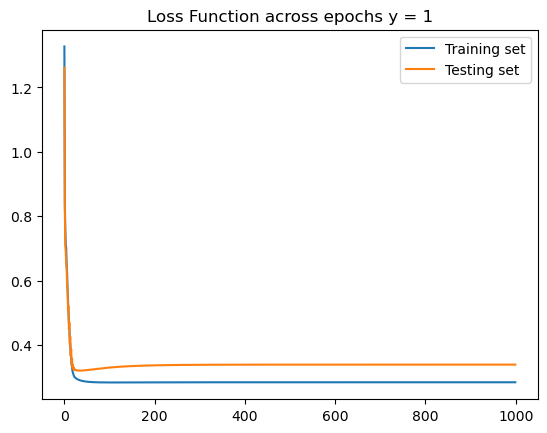

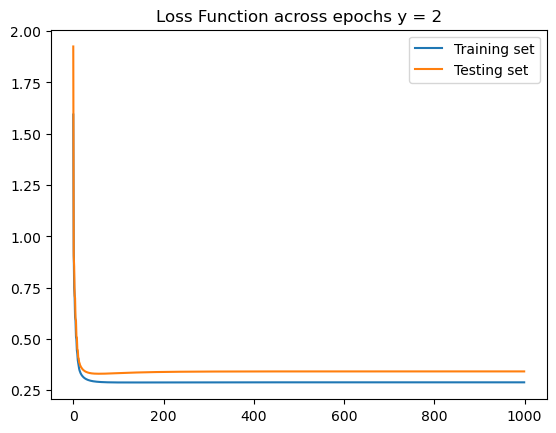

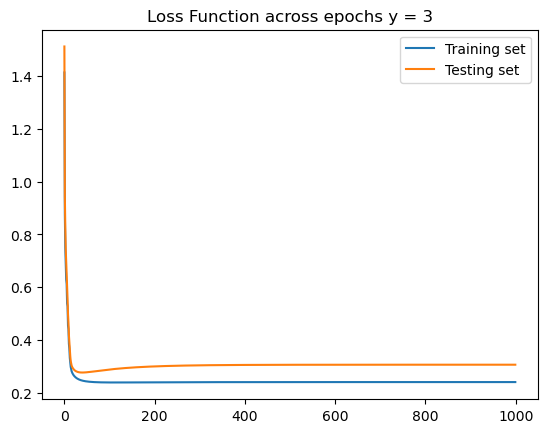

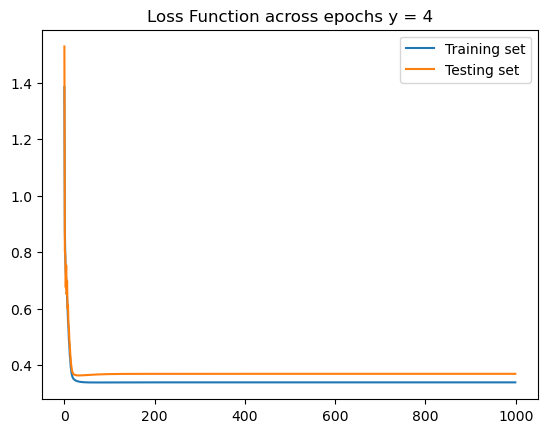

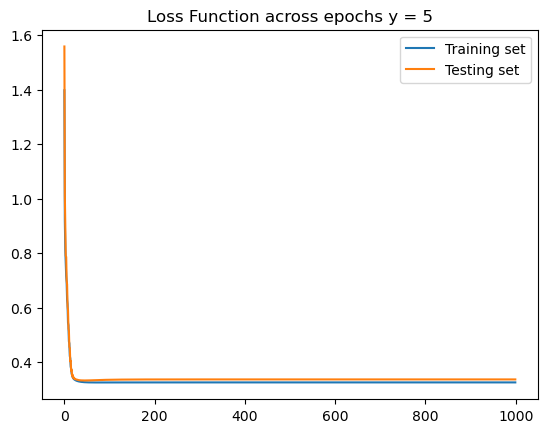

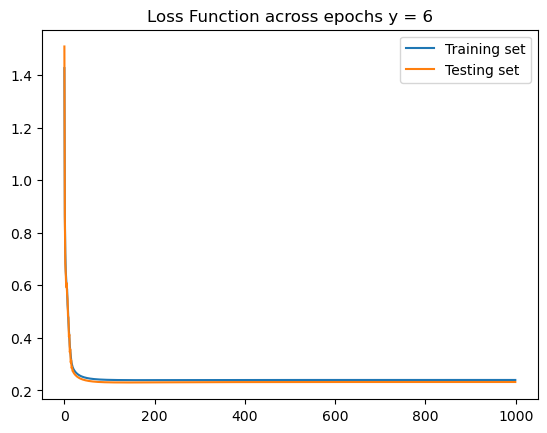

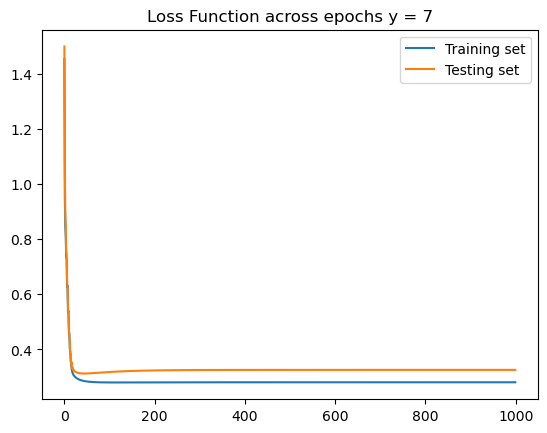

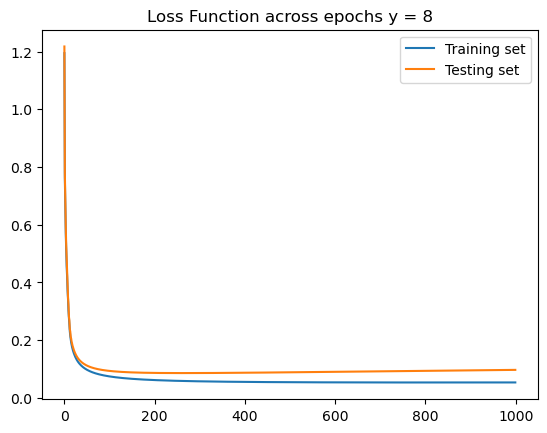

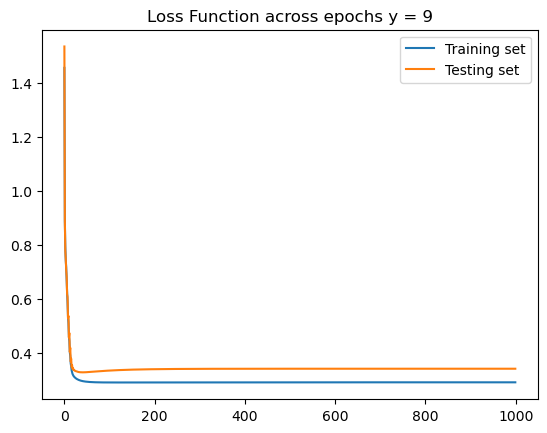

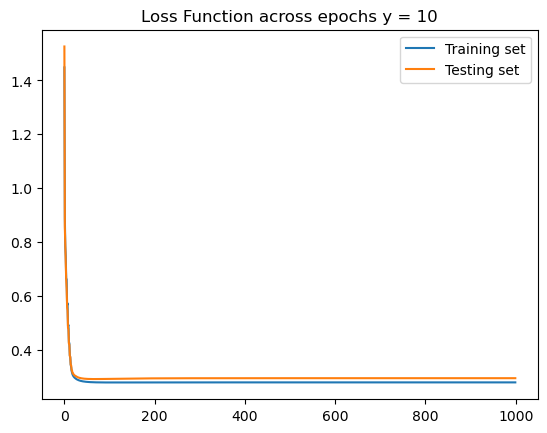

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# estimators
lr_estimator = estimators['lr'][-1].estimator

# params
sss =  StratifiedShuffleSplit(n_splits = 1, test_size = 0.30, random_state = 10)
scaler = StandardScaler()
pca = PCA(n_components = 16, random_state = 23)
transformer = make_pipeline(scaler, pca)

# iterating across unique "y" values
for class_target in np.unique(y):
    # selecting target class
    Y = np.where(y.copy() == class_target, 1, 0)
    
    # spliting matrix into training and test set
    train_index, test_index = list(sss.split(X, Y))[0]
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    # transform variables
    X_train = transformer.fit_transform(X_train)
    X_test = transformer.transform(X_test)
    
    # fitting estimators and getting losses
    lr_estimator.fit(X_train, y_train)
    loss_train, loss_test = lr_estimator.compute_loss(X_train, y_train, X_test, y_test)
    
    plt.plot(loss_train, label = 'Training set')
    plt.plot(loss_test, label = 'Testing set')
    plt.title(f'Loss Function across epochs y = {class_target}')
    plt.legend()
    plt.show()